# DLHub

DLHub is a self-service platform for publishing, applying, and creating new ML/DL models. DLHub will provide: 1) publication capabilities to make models more discoverable, citable, and reusable; 2) the ability to easily run or test existing models; and 3) links to the data and computing infrastructure to re-train models for new applications. Users will benefit from DLHub in many ways. Data scientists can publish their models (i.e., architectures and weights) and methods. Materials scientists can apply existing models to new data with ease (e.g., by querying a prediction API for a deployed mode) and create new models with state-of-the-art techniques. Together, these capabilities will lower barriers to employing ML/DL, making it easier for researchers to benefit from advances in ML/DL technologies. 

## This notebook
This notebook showcases two DLHub use cases, the use of the OQDM pipeline and the use of a BNL model. The OQMD pipeline extracts data from the Materials Data Facility before passing it through three servables on DLHub to transform the input data and perform a prediction. The BNL model uses Globus Auth to pull data from Petrel and generate tags for the data.

## OQMD


Predict XXX with the OQMD pipeline -- this uses a util and featurize transformation before performing the prediction. Data is pulled from the Materials Data Facility and piped through three DLHub servables.

*** Add Diagram


In [1]:
import sys
import os
import json
import requests
import matplotlib
import globus_sdk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## MDF and DLHub imports
from mdf_forge.forge import Forge
import mdf_toolbox
from dlhub_client import DLHub

In [2]:
mdf = Forge()
dl = DLHub()
creds = mdf_toolbox.login(app_name="DLHub", services=["petrel", "data_mdf"])

# Get data from MDF

Search MDF for compositions containing Al and Cu that can be used with the OQMD model.

In [3]:
results = mdf.search_by_elements(elements=["Al","Cu"], 
                                 source_names=["oqmd"], 
                                 limit=10)
compositions = []
for res in results:
    compositions.append({"composition": res['material']['composition']})
df = pd.DataFrame(compositions)
df.head()

,composition
0,Al1Cu4
1,Al1Cu1
2,Al1Cu4
3,Al2Cu1
4,Al2Cu1


## Query DLHub to find models and transformation servables

In [4]:
df_serv = dl.get_servables()
df_serv[['uuid','name']]

,uuid,name
0,1117ac20-3f54-11e8-b467-0ed5f89f718b,oqmd_model
1,9ff7a98c-3f54-11e8-b467-0ed5f89f718b,matminer_featurize
2,e127fb16-5852-11e8-9c2d-fa7ae01bbebc,resnet
3,d5a1653c-3ec5-4947-8c5a-28f6554ec339,matminer_util
4,9553d6a2-6a8d-4cda-8b81-7f38efab67e7,formation_energy
5,8c78939e-6422-4627-80ea-03ed8bfdf6ea,bmg


## Invoke the Matminer util servable to transform the compositions

In [5]:
servable_name = "matminer_util"
servable_id = dl.get_id_by_name(servable_name)

comps = []
for i, row in df.iterrows():
    data = {"data":[{"composition":row['composition']}]}
    res = dl.infer(servable_id, data)
    comps.append(res['composition_object'][0])
df['composition_object'] = comps
df.head()

,composition,composition_object
0,Al1Cu4,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...
1,Al1Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...
2,Al1Cu4,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...
3,Al2Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...
4,Al2Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...


## Use the featurizer to transform the compositions

In [6]:
servable_name = "matminer_featurize"
servable_id = dl.get_id_by_name(servable_name)
features = [] 

for i, row in df.iterrows():
    data = {"data":[{"composition_object":row['composition_object']}]}
    res = dl.infer(servable_id, data)
    features.append(res['features'][0])

df['features'] = features
df.head()

,composition,composition_object,features
0,Al1Cu4,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 25.8, 5.119999999999999, 29..."
1,Al1Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 21.0, 8.0, 13.0, 64.0, 73.0..."
2,Al1Cu4,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 25.8, 5.119999999999999, 29..."
3,Al2Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 18.333333333333332, 7.11111..."
4,Al2Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 18.333333333333332, 7.11111..."


## Perform a prediction against the featurized values

In [7]:
servable_name = "oqmd_model"
servable_id = dl.get_id_by_name(servable_name)
preds = []
for i, row in df.iterrows():
    data = {"data":[{"features":row['features']}]}
    res = dl.infer(servable_id, data)
    preds.append(res['prediction'][0])
df['prediction'] = preds
df.head()

,composition,composition_object,features,prediction
0,Al1Cu4,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 25.8, 5.119999999999999, 29...",-0.183846
1,Al1Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 21.0, 8.0, 13.0, 64.0, 73.0...",-0.179726
2,Al1Cu4,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 25.8, 5.119999999999999, 29...",-0.183846
3,Al2Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 18.333333333333332, 7.11111...",-0.221089
4,Al2Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 18.333333333333332, 7.11111...",-0.221089


## Visualize the result

In [8]:
# TODO -- I think Logan had a way to see what this actually meant?

# BNL model

Use Globus Auth to get a token to pull data from Petrel then pass it through the BNL model.

*** Add Diagram

## Get a list of data from Petrel

In [9]:
# TODO -- put an ls here

## Generate a list of data to invoke against the model

In [10]:
file_start = "https://e38ee745-6d04-11e5-ba46-22000b92c6ec.e.globus.org/Yager/model/raw/01470b9d_varied_sm/0000000"
file_end = ".mat"

data = []
for i in range (5, 7):
    filename = file_start + str(i) + file_end
    data.append({"file": filename, "token": creds['petrel'].access_token})
df_bnl = pd.DataFrame(data)
df_bnl.head()

,file,token
0,https://e38ee745-6d04-11e5-ba46-22000b92c6ec.e...,Aglv1K6XK2OoprvMQNyOBWMYoQ87XBYn26PY8yMw2WWDEy...
1,https://e38ee745-6d04-11e5-ba46-22000b92c6ec.e...,Aglv1K6XK2OoprvMQNyOBWMYoQ87XBYn26PY8yMw2WWDEy...


## Invoke the BNL model

#### This can be a bit slow if the result isn't cached. We are working to optimize.

In [11]:
servable_name = "resnet"
servable_id = dl.get_id_by_name(servable_name)

preds=[]

for d in data:
    data = {"data":[d]}
    res = dl.infer(servable_id, data)
    preds.append(res[0][0])
df_bnl['prediction'] = preds
df_bnl.head()

,file,token,prediction
0,https://e38ee745-6d04-11e5-ba46-22000b92c6ec.e...,Aglv1K6XK2OoprvMQNyOBWMYoQ87XBYn26PY8yMw2WWDEy...,"[1.773031362972688e-05, 0.9997794032096863, 0...."
1,https://e38ee745-6d04-11e5-ba46-22000b92c6ec.e...,Aglv1K6XK2OoprvMQNyOBWMYoQ87XBYn26PY8yMw2WWDEy...,None


## Translate predictions into tags

In [15]:
df_tags = pd.read_csv('./tags.txt',  '\n', header=None) ## Eventually this will be read in from the model metadata in Search

def get_tags(entry):
    df_tmp = pd.DataFrame()
    df_tmp['probability'] = entry['prediction']
    df_tmp['tags'] = df_tags[0]
    return df_tmp


df_p = get_tags(df_bnl.iloc[0])
df_p.sort_values(["probability"], ascending=False).head(10)

,probability,tags
1,0.999779,Beam Off Image
6,0.746068,Halo
13,0.365134,Strong scattering
7,0.082168,High background
12,0.027924,Ring
8,0.012182,Higher orders
15,0.008120,Weak scattering
9,0.001963,Linear beamstop
16,0.001752,Wedge beamstop
2,0.000980,Circular Beamstop


# Metallic Glass Discovery

## In Progress -- This example doesn't work yet

In [55]:
util_path = '{service}/servables/{servable_id}/run'.format(service=dlhub_service,
                                                              servable_id=servable_id)
payload = {"data":['Zr', 'Cr', 'Fe']}
r = requests.post(util_path, json=payload)
lst_res = json.loads(r.text)

In [57]:
lst_res

[None, None, None]

In [33]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matminer.featurizers.composition import ElementFraction
from pymatgen import Composition
import pickle as pkl
import numpy as np
import ternary
import gzip


def ternary_from_data(data, elems=["Left", "Center", "Right"], scale=32):
    _, ax = plt.subplots()
    
    # Make the plot 
    fig, tax = ternary.figure(scale=scale, ax=ax)
    tax.gridlines(color="black", multiple=10)
    tax.boundary(linewidth=1)

    # Generate the heatmap
    sc = heatmap(data, scale, cmap=make_cmap(), ax=ax, vmin=0.5, vmax=1, colorbar=True)
    
    # Make it prettier
    plt.axis('off')
    ax.text(1.05 * scale, -0.05 * scale, elems[0], ha='right', fontsize=12) # 1st elem
    ax.text(.50 * scale, .90 * scale, elems[1], ha='center', fontsize=12) # 2nd elem
    ax.text(-.05 * scale, -.05 * scale, elems[2], ha='left', fontsize=12) # 3rd elem
    
def make_cmap(base='viridis_r', scale_factor=1.5, cutoff=0.9, adjust_factor=0.1):
    """Make a colormap that this scaled to emphasize the top of the range.
    
    Two kinds of emphasis:
        1) Scaling the colormap to have a stronger gradient at the top
        2) Making the colors below a treshold lighter
        
    Inputs:
        base - str, base color map name
        scale_factor - float, how much to exaggerate the range at the top (larger value -> larger scaling)
        cutoff - float, treshold below which to lighten colors (0-1)
        adjust_factor - float, how much to dampen colors (0-1)
    Returns:
        Colormap
    """
    
    # Get the base colormap
    v = cm.get_cmap('viridis_r')
    
    # Scale it
    new_list = v(np.linspace(0,1,300) ** scale_factor)

    # Apply cutoff
    new_list[:int(len(new_list)*cutoff),:3] += (1 - new_list[:int(len(new_list)*cutoff),:3]) * adjust_factor
    return ListedColormap(new_list, name='%s_scaled'%base)


ValueError: not enough values to unpack (expected 2, got 1)

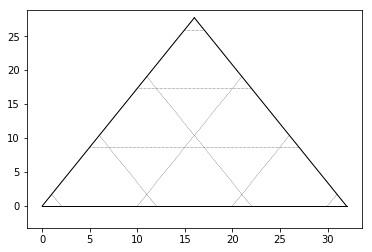

In [34]:
ternary_from_data(lst_res)

In [11]:
servable_name = "bmg"
servable_id = dl.get_id_by_name(servable_name)

data = {"data":['Zr', 'Cr', 'Fe']}
res = dl.infer(servable_id, data)


ValueError: DataFrame constructor not properly called!

In [20]:
df_tags

,0
0,BCC
1,Beam Off Image
2,Circular Beamstop
3,Diffuse high-q
4,Diffuse low-q
5,FCC
6,Halo
7,High background
8,Higher orders
9,Linear beamstop
